In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_26460/424189378.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# Import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# Check out the first few lines of data
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# Organize the data

In [4]:
# Convert from pandas dataframe to tensor | Final column is the outcome variable
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# Transform species to number
labels = torch.zeros(len(data), dtype=torch.long)

# Labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

# Construct and sanity-check the model

In [5]:
# Create a class for the model
class ANN_iris(nn.Module):
  def __init__(self, n_units, n_layers):
    super().__init__()

    # Create empty dictionary to store the layers. Not a normal Python dict. Specifically designed to store layers
    #  of a deep learning network
    self.layers = nn.ModuleDict()
    self.n_layers = n_layers

    ### Input layer
    self.layers['Input'] = nn.Linear(in_features=4, out_features=n_units)

    ### Hidden layers
    for i in range(n_layers):
      self.layers[f'Hidden{i}'] = nn.Linear(in_features=n_units, out_features=n_units) 

    ### Output layer  
    self.layers['Output'] = nn.Linear(in_features=n_units, out_features=3)

  # Forward pass
  def forward(self, data):
    # Input layer (note: the code in the video omits the relu after this layer)
    data = self.layers['Input'](data)

    # Hidden layers
    for layer_i in range(self.n_layers):
      data = F.relu(self.layers[f'Hidden{layer_i}'](data))
      
    # Return output layer
    data = self.layers['Output'](data)

    return data

# Generate an instance of the model and inspect it

In [6]:
n_units_per_layer = 12
n_layers = 4
net = ANN_iris(n_units=n_units_per_layer, n_layers=n_layers)

print(net)

ANN_iris(
  (layers): ModuleDict(
    (Input): Linear(in_features=4, out_features=12, bias=True)
    (Hidden0): Linear(in_features=12, out_features=12, bias=True)
    (Hidden1): Linear(in_features=12, out_features=12, bias=True)
    (Hidden2): Linear(in_features=12, out_features=12, bias=True)
    (Hidden3): Linear(in_features=12, out_features=12, bias=True)
    (Output): Linear(in_features=12, out_features=3, bias=True)
  )
)


# A quick test of running some numbers through the model
This simply ensures that the architecture is internally consistent.

In [7]:
# 10 samples, 4 dimensions
temp_data = torch.randn(10, 4)

# Run it through the DL
y = net(temp_data)

# Exam the shape of the output
print(y.shape), print('')

# And the output itself
print(y)

torch.Size([10, 3])

tensor([[-0.0065, -0.1456,  0.0901],
        [-0.0108, -0.1429,  0.0905],
        [-0.0106, -0.1334,  0.0806],
        [-0.0052, -0.1285,  0.0753],
        [-0.0098, -0.1397,  0.0881],
        [-0.0073, -0.1479,  0.0946],
        [-0.0052, -0.1424,  0.0915],
        [-0.0093, -0.1450,  0.0885],
        [-0.0067, -0.1504,  0.1007],
        [-0.0055, -0.1432,  0.0831]], grad_fn=<AddmmBackward0>)


# Create a function that trains the model

In [11]:
def train_the_model(the_model, num_epochs):
  # Define the loss function and optimizer
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params=the_model.parameters(), lr=0.01)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Forward pass
    y_hat = the_model(data)

    # Compute loss
    loss = loss_func(y_hat, labels)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Final forward pass to get accuracy
  predictions = the_model(data)
  pred_labels = torch.argmax(predictions, axis=1)     # Vector of the index of the largest value in each row (sample)
  total_acc = 100 * torch.mean((pred_labels == labels).float())

  # Total number of trainable parameters in the model
  n_params = sum(p.numel() for p in the_model.parameters() if p.requires_grad)

  # Function outputs
  return total_acc, n_params


# Test the function once

In [12]:
num_epochs = 2500
total_acc = train_the_model(the_model=net, num_epochs=num_epochs)

# Check the outputs. Tuple containing (accuracy, n_params)
total_acc

(tensor(98.6667), 723)

# Now for the experiment!

In [13]:
# Define the model parameters
num_layers = range(1, 6) # Number of hidden layers (1 - 5)
num_units = np.arange(start=4, stop=101, step=3) # Units per hidden layers

# Initialize output matrices
accuracies = np.zeros(shape=(len(num_units), len(num_layers)))
total_params = np.zeros(shape=(len(num_units), len(num_layers)))

# Number of training epochs
num_epochs = 500

# Start the experiment!
for unit_i in range(len(num_units)):
  for layer_i in range(len(num_layers)):

    # Create a fresh model instance
    net = ANN_iris(n_units=num_units[unit_i], n_layers=num_layers[layer_i])

    # Run the model and store the results
    acc, n_params = train_the_model(the_model=net, num_epochs=num_epochs)
    accuracies[unit_i, layer_i] = acc

    # Store the total number of parameters in the model
    total_params[unit_i, layer_i] = n_params

# Show accuracy as a function of model depth

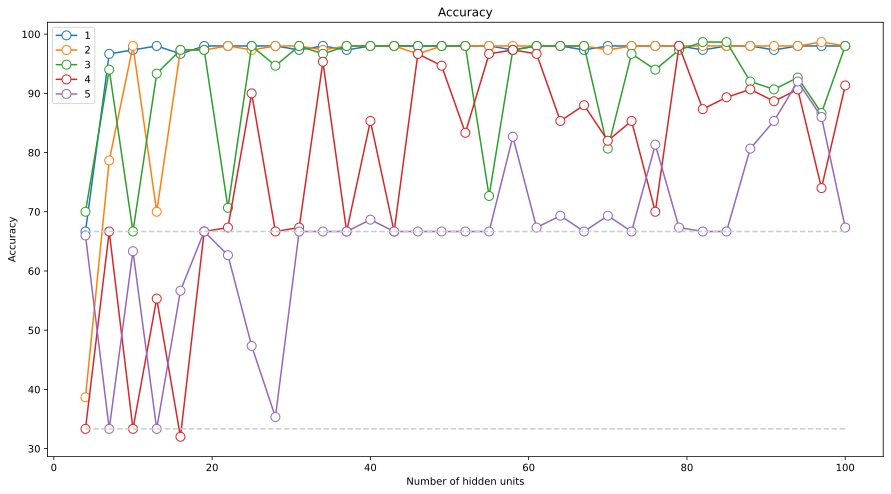

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(num_units, accuracies, 'o-', markerfacecolor='w', markersize=9)
plt.plot(num_units[[0, -1]], [(1/3)*100, (1/3)*100], '--', color=[.8, .8, .8])
plt.plot(num_units[[0, -1]], [(2/3)*100, (2/3)*100], '--', color=[.8, .8, .8])
plt.legend(num_layers)
plt.xlabel('Number of hidden units')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

# Maybe it's simply a matter of more parameters -> better performance?

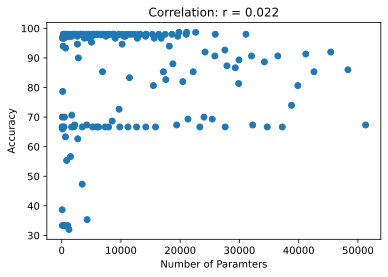

In [17]:
# Vectorize for convenience
total_params_flat = total_params.flatten()
accuracies_flat = accuracies.flatten()

# Correlation between them
r = np.corrcoef(total_params_flat, accuracies_flat)[0, 1]

# Scatter plot
plt.plot(total_params_flat, accuracies_flat, 'o')
plt.xlabel('Number of Paramters')
plt.ylabel('Accuracy')
plt.title(f'Correlation: r = {np.round(r, 3)}')
plt.show()

# Additional explorations
1) Try it again with 1000 training epochs. Do the deeper models eventually learn?

2) The categories are coded a "0", "1", and "2". Is there something special about those numbers?
   Recode the labels to be, e.g., 5, 10, and 17. Or perhaps -2, 0, and 2. Is the model still able to learn?